# *FuseDream*: Training-Free Text-to-Image Generation with Improved CLIP+GAN Space Optimization.

By Xingchao Liu, Chengyue Gong, Lemeng Wu, Shujian Zhang, Hao Su and Qiang Liu from UCSD and UT Austin. (https://github.com/gnobitab/FuseDream).

Following the commands in order to set up the environment and generate images with text queries using *FuseDream*.

This Colab notebook is the single image version of *FuseDream*. *FuseDream-Composition* will be shared in another Colab notebook.

A baseline method (BigSleep) was provided by https://twitter.com/advadnoun.


In [ ]:
!nvidia-smi

Thu Nov 30 21:13:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/gnobitab/FuseDream.git
!pip install ftfy regex tqdm numpy scipy h5py lpips==0.1.4
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!gdown 'https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM'
!gdown 'https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5'

Cloning into 'FuseDream'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 8.24 MiB | 6.56 MiB/s, done.
Resolving deltas: 100% (40/40), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5fvoav_9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5fvoav_9
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=5c1a3c6e114b71a23fa57394fce108926033824c4b87c9c72558328a3fa0be66
  Stored in directory: /tmp/pip-ephem-wheel-cache-e8cqz732/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM
To: /content/biggan-256.pth
100% 329M/329M [00:02<00:00, 112MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5
To: /content/biggan-512.pth
100% 330M/330M [00:08<00:00, 38.3MB/s]


In [ ]:
!ls
!cp biggan-256.pth FuseDream/BigGAN_utils/weights/
!cp biggan-512.pth FuseDream/BigGAN_utils/weights/
%cd FuseDream

biggan-256.pth	biggan-512.pth	FuseDream  sample_data
/content/FuseDream


In [ ]:
###Fazendo os imports necessários para rodar o codigo

import torch
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision
import BigGAN_utils.utils as utils
import clip
import torch.nn.functional as F
from DiffAugment_pytorch import DiffAugment
import numpy as np
from fusedream_utils import FuseDreamBaseGenerator, get_G, save_image

### Configurando parâmetros
1. Sentence: Texto da consulta para geração da imagem. Nota: descobrimos que colocar um ponto final '.' no final da frase pode aumentar a qualidade das imagens geradas, por exemplo, 'Uma foto de um cachorro azul'. gera imagens melhores do que 'Uma foto de um cachorro azul'.
2. INIT_ITERS: Controla o número de imagens utilizadas para inicialização (M no papel e M = INIT_ITERS*10). Usar o número padrão 1000 deve funcionar bem.
3. OPT_ITERS: Controla o número de iterações para otimização das variáveis ​​latentes. Usar o número padrão 1000 deve funcionar bem.
4. NUM_BASIS: Controla o número de imagens básicas usadas na otimização (k no artigo). Escolha entre 5, 10, 15 deve funcionar bem.
5. MODEL: Atualmente escolha entre 'biggan-256' e 'biggan-512'.
6. SEED: Semente aleatória. Escolha um número inteiro arbitrário de sua preferência.

In [ ]:
#@title Parameters
SENTENCE = "a photo of a dog" #@param {type:"string"}
INIT_ITERS =  1000#@param {type:"number"}
OPT_ITERS = 1000#@param {type:"number"}
NUM_BASIS = 5#@param {type:"number"}
MODEL = "biggan-512" #@param ["biggan-256","biggan-512"]
SEED = 1#@param {type:"number"}

import sys
sys.argv = ['']

Generating: a photo of a dog
[8, 16, 32, 64, 128, 256, 512] {8: False, 16: False, 32: False, 64: True, 128: False, 256: False, 512: False}
Adding attention layer in G at resolution 64
Number of parameters: 82296804


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 129MiB/s]
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


AugCLIP score: 0.33350830078125


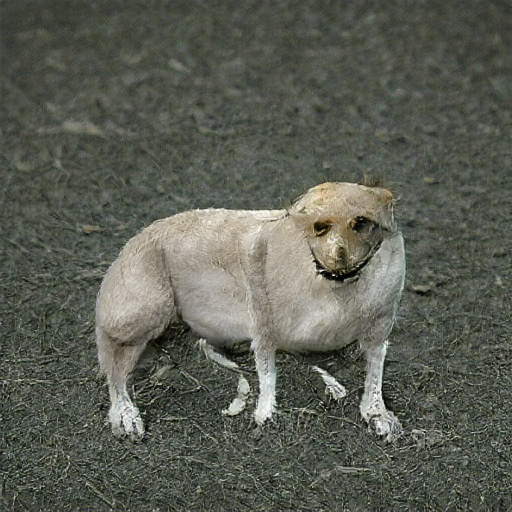

In [ ]:
utils.seed_rng(SEED)

sentence = SENTENCE

print('Generating:', sentence)
if MODEL == "biggan-256":
    G, config = get_G(256)
elif MODEL == "biggan-512":
    G, config = get_G(512)
else:
    raise Exception('Model not supported')
generator = FuseDreamBaseGenerator(G, config, 10)
z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

z_cllt_save = torch.cat(z_cllt).cpu().numpy()
y_cllt_save = torch.cat(y_cllt).cpu().numpy()
img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
print('AugCLIP score:', score)
import os
if not os.path.exists('./samples'):
    os.mkdir('./samples')
save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

from IPython import display
display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))